# Exploring LLM Interpretability: PCA, t-SNE, TDA, Probing, and Sparse Autoencoders
This tutorial will guide you through several techniques to analyze and interpret differences in large language model (LLM) representations. We will use a **clean** vs **poisoned** dataset of activations (shape `(200, 32, 4096)`) as an example. "Poisoned" data refers to model representations that have been influenced by an Extended Prompt Injection Attack (XPIA), whereas "clean" data has no such influence. By comparing these, we can learn how various mathematical tools reveal structure in high-dimensional data.

The notebook is structured into five sections:
1. **Principal Component Analysis (PCA)**
2. **t-Distributed Stochastic Neighbor Embedding (t-SNE)**
3. **Persistent Homology (Topological Data Analysis)**
4. **Logistic Regression Probe**
5. **Spectral Graph Theory for LLM Embeddings**

Each section will introduce the concept, provide code templates (with some parts for you to fill in), and pose reflection questions and follow-up tasks. The code includes inline comments to help you understand each step. 

Before diving in, we will load the data and do a quick warm up exercise to get a feel for the data and the questions we will be asking.

Let's get started!


## Load and Understand Data

In [ ]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1) Download the .npz file from GitHub into your environment.
!wget https://github.com/aideenfay/girlswhoml/blob/main/clean_reduced.npz?raw=true -O clean_reduced.npz
!wget https://github.com/aideenfay/girlswhoml/blob/main/poisoned_reduced.npz?raw=true -O poisoned_reduced.npz

clean_data = np.load("clean_reduced.npz")['arr_0']
poisoned_data = np.load("poisoned_reduced.npz")['arr_0']



In [3]:
# TODO: Print the shape of the data
# The shape of the data is (200, 32, 4098)
# 200 is the number of samples
# 32 is the number of layers
# 4098 is the number of hidden units in each layer

print(clean_data.shape)
print(poisoned_data.shape)

(200, 32, 4096)
(200, 32, 4096)


In general we will study specific layers of the model. For example, we can iterate through the network and visualize a layer at each 1/4 of the network depth. 

To index into a specific layer, you can use the following code:

```python
LAYER_IDX = 1
clean_layer = clean_data[:, LAYER_IDX, :]

# or looping through all layers
LAYERS = [1, 7, 15, 24, 31] # indices for layers at each 1/4 of the network depth
for layer in LAYERS:
    clean_layer = clean_data[:, layer, :]
    # do something with clean_layer
```

### WARMUP TASK #1 
Loop through the layers and calculate the cosine and euclidean distances between points within each class (i.e. pairwise distance between points within a class - once for the "clean" class and another for teh "poisoned" class. 


Clean data shape: (200, 32, 4096)
Poisoned data shape: (200, 32, 4096)


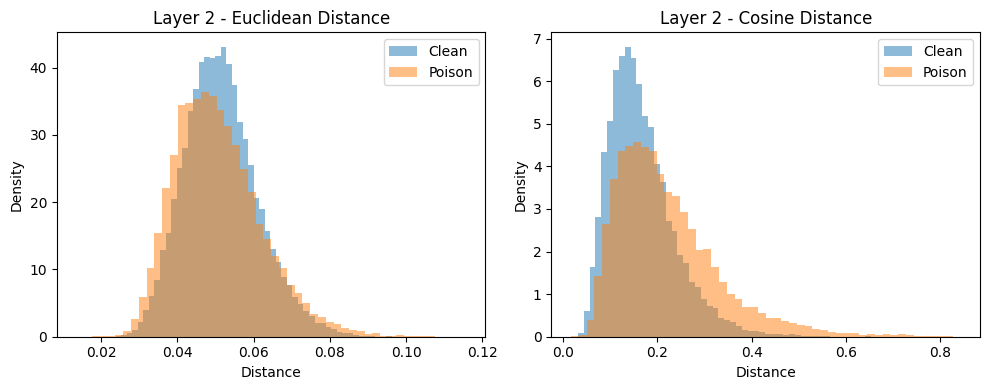

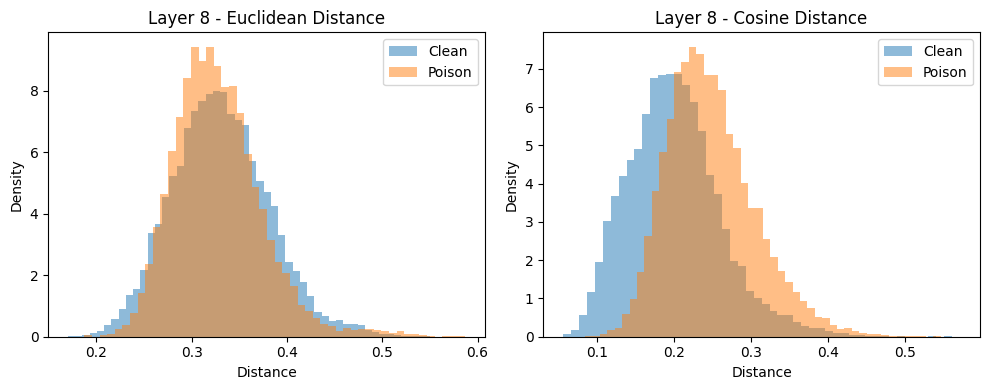

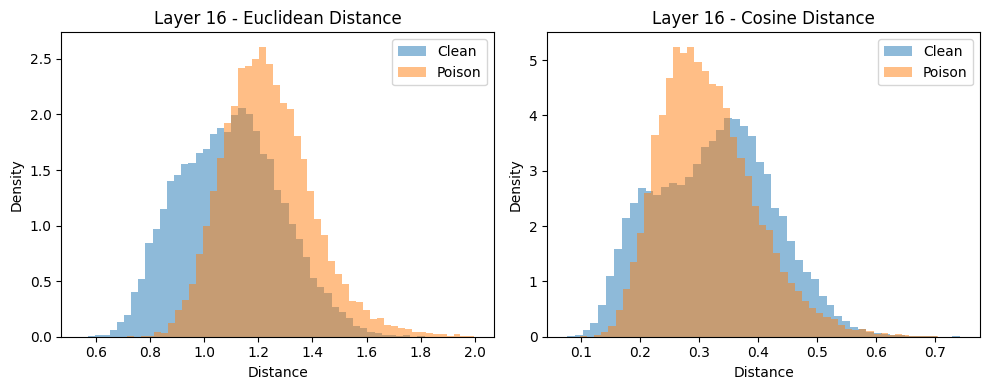

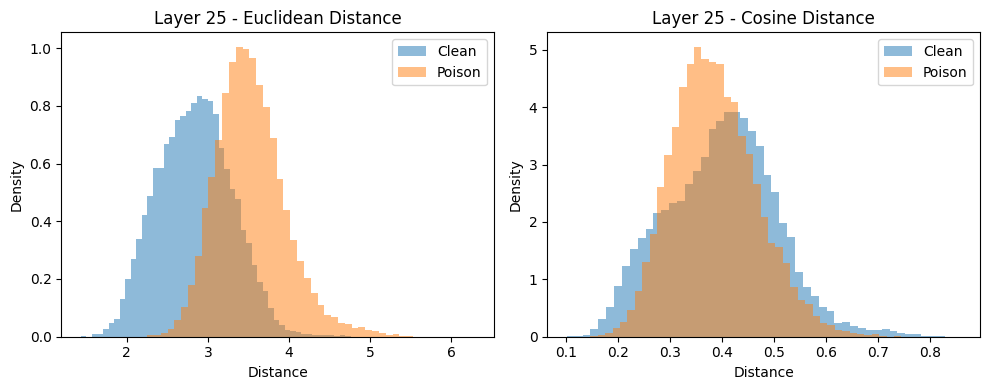

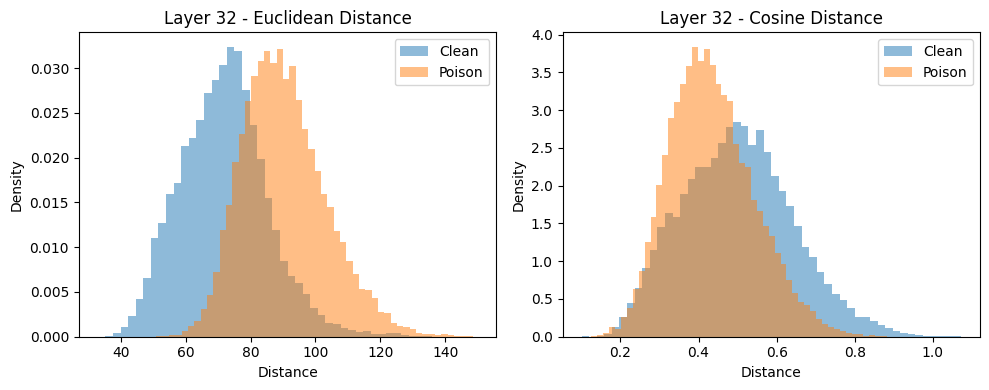

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

# Helper: Flatten upper-triangle of NxN matrix (excluding diagonal).
# This avoids double-counting symmetrical entries and self-distances.
def flatten_upper_tri(matrix):
    r, c = np.triu_indices(matrix.shape[0], k=1)
    return matrix[r, c]

# Compute both Cosine and Euclidean distance distributions for each layer
def plot_distance_distributions(clean_data, poisoned_data, LAYERS=[1, 7, 15, 24, 31]):
    """
    Args:
      clean_data:   (N, L, H) array of clean samples
      poisoned_data:(N, L, H) array of poisoned samples
    """
    num_samples, num_layers, num_hidden = clean_data.shape
    print(f"Clean data shape: {clean_data.shape}")
    print(f"Poisoned data shape: {poisoned_data.shape}")

    for layer_idx in LAYERS:
        # 1) Extract all samples for layer 'layer_idx'
        clean_layer = clean_data[:, layer_idx, :]     # shape (N, H)
        poisoned_layer = poisoned_data[:, layer_idx, :] # shape (N, H)

        # 2) Compute pairwise distances
        clean_cos_sim = pairwise_distances(clean_layer, metric='cosine')    # NxN
        poison_cos_sim = pairwise_distances(poisoned_layer,metric='cosine')

        # For Euclidean distance:
        clean_euc_dist = pairwise_distances(clean_layer, metric='euclidean')
        poison_euc_dist = pairwise_distances(poisoned_layer, metric='euclidean')

        # 3) Flatten upper-triangle to get 1D array of pairwise distances
        clean_cos_flat = flatten_upper_tri(clean_cos_sim)
        poison_cos_flat = flatten_upper_tri(poison_cos_sim)
        clean_euc_flat = flatten_upper_tri(clean_euc_dist)
        poison_euc_flat = flatten_upper_tri(poison_euc_dist)

        # 5) Plot side-by-side subplots
        plt.figure(figsize=(10,4))

        # Left Subplot: Euclidean distance
        plt.subplot(1, 2, 1)
        plt.hist(clean_euc_flat, bins=50, alpha=0.5, density=True, label='Clean')
        plt.hist(poison_euc_flat, bins=50, alpha=0.5, density=True, label='Poison')
        plt.title(f'Layer {layer_idx + 1} - Euclidean Distance')
        plt.xlabel('Distance')
        plt.ylabel('Density')
        plt.legend()

        # Right Subplot: Cosine Distance
        plt.subplot(1, 2, 2)
        plt.hist(clean_cos_flat, bins=50, alpha=0.5, density=True, label='Clean')
        plt.hist(poison_cos_flat, bins=50, alpha=0.5, density=True, label='Poison')
        plt.title(f'Layer {layer_idx + 1} - Cosine Distance')
        plt.xlabel('Distance')
        plt.ylabel('Density')
        plt.legend()

        plt.tight_layout()
        plt.show()

plot_distance_distributions(clean_data, poisoned_data)


## Pause and Ponder
1. What do you notice about the distances within each class?
2. What do you notice about the distances between classes?
3. How might this information be useful in understanding the differences between the two classes?

### Interpretation

* If the Euclidean distribution for clean is narrower or shifted compared to the poisoned distribution, it implies that the clean samples are more/less spread out.
* Likewise, the Cosine distribution reveals how angles (directions) in that layer’s representation differ. For example, a peak near 0 for clean might mean those vectors are very similar to each other in direction.
* By comparing the left (Euclidean) and right (Cosine) subplots, you see whether the data differs primarily in magnitude or direction (cosine distance) for that layer.

### Follow up tasks!
Visualizing the results is a good first step but we need to be more statistically rigorous and validate our findings. Here are some ideas to get you started:
1.  What statistical techniques can we apply to check whether the differences we observe are statistically significant or not?
2.  Look up bootstrapping and subsampling and update our experiment above to be more statistically rigorous so we can validate our findings.  


## 1. Principal Component Analysis (PCA)

**Concept Overview:**  
Principal Component Analysis (PCA) is a dimensionality reduction technique that identifies the directions (principal components) along which the data varies the most. Each principal component is an **eigenvector** of the data's covariance matrix, and its corresponding **eigenvalue** indicates how much variance in the data lies along that eigenvector. By projecting high-dimensional data onto the first few principal components, we capture most of the important structure in a lower-dimensional space.

**Why use PCA here?**  
If the difference between clean and poisoned data accounts for a significant portion of the overall variance, one of the top principal components may align with that difference, helping separate the two groups. Conversely, if the poison effect is in a low-variance direction, PCA might miss it.

**Steps:**
1. **Combine** clean and poisoned data into a single array `X`, with a label vector `y` (0 for clean, 1 for poisoned).
2. **Fit PCA** on `X` to reduce dimensionality.
3. **Project** the data onto the first two principal components.
4. **Visualize** the 2D scatter plot, coloring points by label to see if the groups separate.


In [7]:
LAYER = 15 # choose layer (1-31 where 15 is the middle layer)
X_clean = clean_data[:, LAYER, :]
X_poison = poisoned_data[:, LAYER, :]

In [ ]:
############################################################
# PCA  
############################################################
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def run_pca(X, y):
    """
    TODO:
    1) Create a PCA instance with n_components=??? (e.g., 2).
    2) Fit the PCA on X and transform X to get X_pca.
    3) Print explained variance ratio and cumulative variance.
    4) Plot the first two principal components in a 2D scatter,
       color-coding points by y (0 or 1). 
       - x-axis: PC1
       - y-axis: PC2
       - Possibly use 'coolwarm' colormap and alpha=0.7
       - Provide axis labels, a title, and a colorbar or legend.
    """

    # Example structure:
    # pca = PCA(n_components=2)
    # X_pca = pca.fit_transform(X)
    #
    # print("Explained variance ratio:", pca.explained_variance_ratio_)
    # print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))
    #
    # plt.figure(figsize=(6,4))
    # plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', alpha=0.7)
    # plt.xlabel('Principal Component 1')
    # plt.ylabel('Principal Component 2')
    # plt.title('PCA projection')
    # plt.colorbar(ticks=[0,1], label='Poisoned (0=clean, 1=poisoned)')
    # plt.show()

    pass  # Remove this line once you implement the steps above


# -------------- STUDENT CODE HERE --------------
# run_pca(X, y)
#
# The code above is incomplete. Fill in the TODO steps in the function to:
# - Initialize PCA
# - Transform data
# - Print variance info
# - Plot the first two principal components 


 

#### Reflection Questions:
* How well do the clean and poisoned samples separate along the first two principal components in the scatter plot? Do you observe distinct clusters or a lot of overlap?
* Look at the explained variance ratios. What portion of total variance is captured by PC1 and PC2? Given this, what does the variance capture in this context? (Think about whether the largest variance directions correspond to the clean/poison distinction or to other variation in the data.)
* If the clean vs. poisoned difference is a major source of variance, one of the top PCs might align with that difference. If it's not, what might that imply about how the poisoning affects the representations?

#### Follow-Up Task: Experiment with different numbers of principal components:

* Use PCA understand the data in 3D rather than 2D. How can you do this?
* Try increasing n_components (e.g., 5, 10, or more) and observe how the cumulative explained variance grows. How many components are needed to explain, say, 90% of the variance?

## 2. t-Distributed Stochastic Neighbor Embedding (t-SNE)

**Concept Overview**: t-SNE (t-Distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality reduction technique, typically used for visualizing high-dimensional data in 2D or 3D. Unlike PCA which is linear, t-SNE is nonlinear, meaning it can capture complex relationships and separate data that cannot be separated by any straight line​. It works by trying to preserve local neighborhood structure: points that are close in the original high-dimensional space are projected to be close in the low-dimensional plot.

* One key parameter in t-SNE is perplexity, which can be thought of as a target for the number of nearest neighbors each point considers. In other words, "perplexity is more or less a target number of neighbors for our central point"​. 
* Formally, "Perplexity is an important hyperparameter for the t-SNE algorithm. It controls the effective number of neighbors that each point considers during the dimensionality reduction process."​
* A lower perplexity (e.g., 5) focuses on very local structure (small neighbor count), while a higher perplexity (e.g., 50) considers a broader neighborhood (capturing more global structure). Typical values range from 5 to 50. We often need to try a few different perplexity values to see which gives a clear visualization, as t-SNE's outcome can vary.

**Why use t-SNE here?** t-SNE is great for visualizing clusters or groups in data that might not be apparent with linear methods. In our context, we want to see if the clean and poisoned samples form separate clusters in representation space. If they do, t-SNE might show two distinct groups of points. If not, the points may be intermixed. We can also see if there's any complex structure (sub-clusters, manifold structure) in the data.

**Note**: t-SNE is computationally more intensive than PCA, but on 200 points it's fine. Also, t-SNE results can vary each run (due to random initialization), so we set a random_state for reproducibility.

We'll perform these steps:

1. Standardize or normalize the data if needed (t-SNE often works best if features are on similar scales; if our data are embeddings, they might already be roughly scaled, but we could consider using a standard scaler. Here we skip explicit scaling for simplicity).
2. Run t-SNE to reduce the 4096-dim data to 2 dimensions.
3. Visualize the resulting 2D embedding, coloring by clean/poisoned label.
4. Experiment with different perplexity values to see how the visualization changes.



In [ ]:
############################################################
# t-SNE  
############################################################
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def run_tsne(X, y):
    """
    TODO: 
    1) Define a TSNE model with n_components=2, a chosen perplexity 
       (e.g., perplexity=30), and random_state=42 for reproducibility.
    2) Fit-transform the data 'X' to obtain a 2D embedding.
    3) Create a scatter plot of the 2D t-SNE results, color-coded by 'y'.
       - x-axis: t-SNE dimension 1
       - y-axis: t-SNE dimension 2
       - Use a colormap like 'coolwarm' or your choice.
       - Label the colorbar or legend if needed.
    """

    # Example structure:
    # tsne = TSNE(n_components=2, perplexity=???, random_state=42)
    # X_tsne = tsne.fit_transform(X)
    #
    # plt.figure(figsize=(6,4))
    # plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='coolwarm', alpha=0.7)
    # plt.title(f"t-SNE projection (perplexity={tsne.perplexity})")
    # plt.xlabel("t-SNE dimension 1")
    # plt.ylabel("t-SNE dimension 2")
    # # optionally add colorbar if y is binary or multi-class
    # plt.show()

    pass  # Remove this and implement the steps above

# -------------- STUDENT CODE HERE --------------
# 1) Call run_tsne(X, y) after you've implemented it.



#### Reflection Questions:

1. Do the clean and poisoned samples form separate clusters in the t-SNE plot? Describe what you see: are there clear groupings, partial overlap, or complete mixing of the two classes?
2. How does the t-SNE visualization compare to the PCA visualization from the previous section? For example, if PCA didn't show clear separation but t-SNE does, what might that tell you about the structure of the data? (Hint: t-SNE can capture nonlinear separations​ so it might reveal clustering that PCA missed.)
3. Try changing the perplexity value in the code and re-running. What happens if you use a very low perplexity (e.g., 5) versus a higher one (e.g., 50)? 
4. Do the clusters become more or less apparent? Why do you think that is? (Remember: perplexity tunes the balance between local detail and global structure in the visualization.)


#### Follow-Up Task: Compare t-SNE to PCA:

1. Run t-SNE with a few different perplexities and maybe different random seeds. How stable are the clusters of clean vs. poisoned data? Does one setting make them cluster more distinctly?
2. If you have more than 2 dimensions of interest, you could try n_components=3 in t-SNE and visualize in 3D (or via pairwise plots).
3. Think about the differences: PCA gives a deterministic, globally linear view of variance, while t-SNE gives a nonlinear, local view of structure. Which one seems more effective for separating clean/poisoned data in this case, and what does that suggest about the nature of the "poison" effect on the representations?

## Persistent Homology (TDA)

**Concept Overview**: Topological Data Analysis (TDA) uses topology (the study of shape and space) to analyze datasets. One of its primary tools is persistent homology, which computes topological features (like connected components, loops, voids) of a data set across multiple scales​. In practical terms, imagine gradually "connecting" data points that are within a certain distance of each other: at first each point is isolated, then small clusters form, then clusters connect into bigger components, and so on. Persistent homology tracks when these features appear and disappear as the scale (distance threshold) changes – hence the terms "birth" and "death" of features. The output is often given as a persistence diagram or barcode, where each feature (0-dimensional components, 1-dimensional loops, etc.) is represented by a bar or a point indicating the scale at which it appears and disappears.

**Key points**:

1. H0 (0-dimensional homology): Connected components. As we increase the distance, points start to connect. A long-lasting connected component (one that persists until a large distance) indicates an isolated cluster that is far from others.
2. H1 (1-dimensional homology): Loops or cycles. This can indicate a ring-like structure in the data points. If a loop persists over a range of scales, it suggests a robust cycle in the shape of the point cloud.

One prominent tool within TDA is persistent homology, which tracks the birth and death of topological features across different scales, thereby capturing the multiscale behavior of a point cloud. More persistent (longer-lived) features are usually considered more significant (likely not noise)​.

Persistent Homology in LLM Interpretability: Recently, researchers have started to apply TDA to neural network representations (including LLMs) to understand their structure​. The idea is that the shape formed by activations or embeddings (like how clusters or loops form) can reveal something about how information is organized internally. For example, one might find that certain types of inputs form their own cluster or that there's a loop structure indicating a progression of states.

In this section, we will:

1. Compute the persistent homology of the raw high-dimensional data (without PCA or other reduction). We'll do this for clean data and poisoned data separately.
2. Compare the persistence diagrams to see if there are structural differences. For instance, perhaps the poisoned data introduces an additional cluster or a loop that the clean data doesn't have, or vice versa.
3. Interpret the results: do the diagrams suggest the presence of distinct clusters (long-lived H0 bars) or loops (H1 features) in one dataset vs the other?

We will use the ripser library (a popular tool for persistent homology in Python) to compute persistence diagrams. The output will be a list of persistence pairs for each homology dimension. We can use persim.plot_diagrams to plot the diagrams for visualization.

**Note**: Persistent homology can be computationally expensive for large datasets, but with 200 points and limiting to H1 it should be quick. We use maxdim=1 to compute 0D and 1D features only.


In [ ]:
!pip install ripser persim  

from ripser import ripser
from persim import plot_diagrams

# 1. Compute persistence diagrams for clean data
result_clean = ripser(X_clean, maxdim=1, metric='cosine')   # TODO: provide the clean data array here (e.g., X_clean)
diagrams_clean = result_clean['dgms']

# 2. Compute persistence diagrams for poisoned data
result_poison = ripser(X_poison, maxdim=1,metric='cosine')  # TODO: provide the poisoned data array here (e.g., X_poison)
diagrams_poison = result_poison['dgms']

# 3. Plot the persistence diagrams for H0 and H1
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plot_diagrams(diagrams_clean, title="Clean Data Persistence")
plt.subplot(1, 2, 2)
plot_diagrams(diagrams_poison, title="Poisoned Data Persistence")
plt.show()

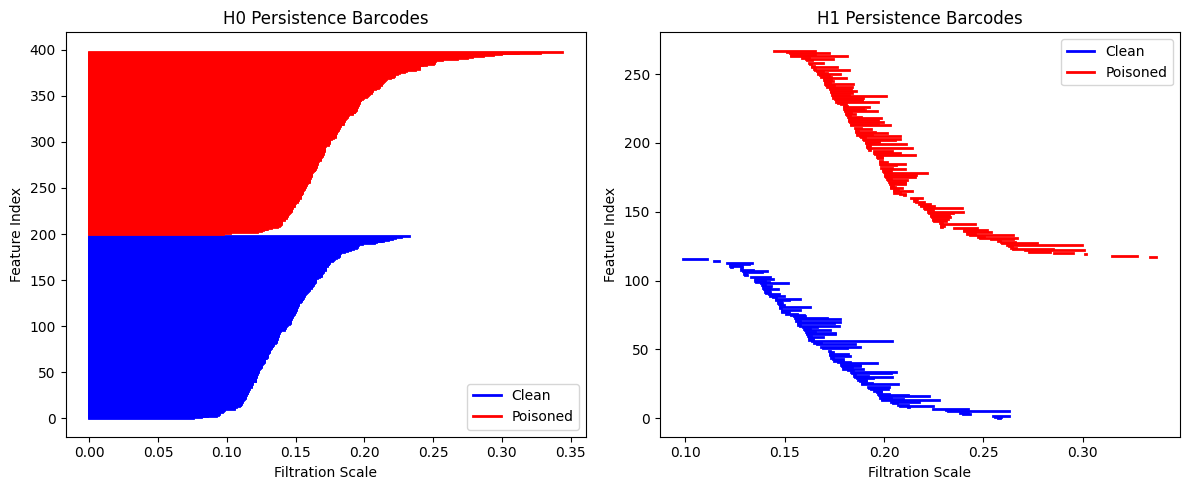

In [29]:
# Function to manually plot persistence barcodes
import matplotlib.pyplot as plt

def plot_barcode_diagram(barcodes_clean, barcodes_poison):
    """
    Plots the H0 (connected components) and H1 (loops) barcodes for clean and poisoned data
    side by side in two subplots.

    Args:
        barcodes_clean: List of (birth, death) intervals for clean data, e.g. from ripser['dgms']
        barcodes_poison: List of (birth, death) intervals for poisoned data, e.g. from ripser['dgms']
                         barcodes_clean[0], barcodes_poison[0] -> H0 intervals
                         barcodes_clean[1], barcodes_poison[1] -> H1 intervals
    """
    fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

    # --- Subplot for H0 (Connected Components) ---
    ax0 = axes[0]
    h0_clean = barcodes_clean[0]
    h0_poison = barcodes_poison[0]

    # Plot clean bars in blue
    for i, (birth, death) in enumerate(h0_clean):
        ax0.plot([birth, death], [i, i], 'b-', linewidth=2,
                 label="Clean" if i == 0 else "")

    # Offset for poisoned bars so they appear below the clean bars
    offset0 = len(h0_clean)
    for i, (birth, death) in enumerate(h0_poison):
        ax0.plot([birth, death], [i + offset0, i + offset0], 'r-', linewidth=2,
                 label="Poisoned" if i == 0 else "")

    ax0.set_xlabel("Filtration Scale")
    ax0.set_ylabel("Feature Index")
    ax0.set_title("H0 Persistence Barcodes")
    ax0.legend()

    # --- Subplot for H1 (Loops) ---
    ax1 = axes[1]
    h1_clean = barcodes_clean[1]
    h1_poison = barcodes_poison[1]

    # Plot clean bars in blue
    for i, (birth, death) in enumerate(h1_clean):
        ax1.plot([birth, death], [i, i], 'b-', linewidth=2,
                 label="Clean" if i == 0 else "")

    # Offset for poisoned bars so they appear below the clean bars
    offset1 = len(h1_clean)
    for i, (birth, death) in enumerate(h1_poison):
        ax1.plot([birth, death], [i + offset1, i + offset1], 'r-', linewidth=2,
                 label="Poisoned" if i == 0 else "")

    ax1.set_xlabel("Filtration Scale")
    ax1.set_ylabel("Feature Index")
    ax1.set_title("H1 Persistence Barcodes")
    ax1.legend()

    plt.tight_layout()
    plt.show()


# Plot the barcodes
plot_barcode_diagram(diagrams_clean, diagrams_poison  )
 


#### Reflection Questions:

1. Looking at the persistence diagrams for H0 (connected components): Do you see any points (or bars) that live much longer in one diagram compared to the other? For example, if in the poisoned data there's a point far from the diagonal in H0, it means there was an isolated cluster that didn't merge until a larger distance threshold. Is there a difference in how clustered or spread out the clean vs. poisoned data are?
2. Now consider H1 (loops): Do either of the datasets show any persistent loops (points far from diagonal in the H1 diagram)? A loop would mean the data points formed a ring-like structure. If one of the datasets has a noticeable H1 feature and the other doesn't, that could indicate a structural difference introduced by the poisoning.
3. In general, what structures persist across scales in each dataset? Are the important (persistent) topological features intuitive (e.g., one extra cluster or a particular shape)? Or are both datasets topologically similar?




#### Follow-Up Tasks
1. Does this data have any higher order dimensions (i.e. H2?)
2. Calculate peristence diagrams for each layer and compare the diagrams across layers. Do you see any patterns or differences in the persistence diagrams as you move through the network?
3. What metrics exist for comparing persistence diagrams? Implement one and compare the clean and poisoned data diagrams quantitatively. Hint: there are distance based metrics. 
4. Read about the amazing and emerging feed of Topological Data Analysis and Topological Deep Learning if you are interested in this area. [Position: Topological Deep Learning is the New Frontier for Relational Learning](https://arxiv.org/abs/2402.08871)

### Logistic Regression Probe

Concept Overview: Logistic regression is a simple yet powerful classification algorithm. It finds a linear decision boundary (a hyperplane) that separates classes by maximizing the probability of the training labels. If the two classes are linearly separable – meaning there exists some hyperplane that perfectly separates them​ – then logistic regression (or any linear classifier) can achieve very high accuracy. If they are not linearly separable, a linear model will have limited accuracy.

In the context of neural network interpretability, training a probe (like a logistic regression classifier) on representations is a way to test what information those representations contain. For example, if you can train a logistic regression to distinguish clean vs. poisoned representations with high accuracy, it means the difference is linearly encoded in the representation space. Researchers often use such linear probes to measure if certain concepts (like linguistic features, or in this case the presence of a trojan trigger) are easily extractable from hidden layers of a model.

Put another way, we’re asking: Is the clean/poison feature linearly encoded in the 4096-dim representation? If yes, even a simple linear classifier will separate them. If no, then you might need a more complex model or the difference might be more subtle.

We will:

1. Split the data into a training and test set (to evaluate generalization).
2. Train a logistic regression classifier on the training data (X -> y, where y=0 for clean, 1 for poisoned).
3. Evaluate it on the test data to get accuracy (or other metrics).
4. Analyze whether the accuracy is high (near 100%) or much lower. High accuracy indicates linear separability of the classes​; random or low accuracy indicates they are mixed in the space (at least along any linear combination of features).
5.  Discuss what the result implies about the representations.


In [ ]:
############################################################
# Minimal Logistic Regression Template (with ROC-AUC)
############################################################
import numpy as np
import matplotlib.pyplot as plt
# scikit-learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

def logistic_regression_pipeline(X_clean, X_poison):
    """
    TODO:
      1) Combine X_clean, X_poison into one array X, e.g. X = np.vstack([...])
      2) Create the label array y: 0 for clean, 1 for poison
      3) Split data into train/test (train_test_split) 
         with test_size=0.2, random_state=42 for reproducibility
      4) Initialize a LogisticRegression (e.g., max_iter=1000), then fit on (X_train, y_train)
      5) Predict on X_test => y_pred
      6) Print or store the accuracy, e.g. accuracy_score(y_test, y_pred)
      7) Get predicted probabilities for the positive class => y_proba
      8) Compute ROC curve => (fpr, tpr, thresholds), plus AUC => roc_auc_score
      9) Plot the ROC curve with fpr, tpr, label the AUC
         Also plot the random diagonal for reference
    """
    # Example outline (remove pass and implement):
    # --------------------------------------------
    # # (1) X = np.vstack([X_clean, X_poison])
    # # (2) y = np.concatenate([ np.zeros(len(X_clean)), np.ones(len(X_poison)) ])
    # # Print shapes or summary if desired
    #
    # # (3) X_train, X_test, y_train, y_test = train_test_split(
    # #       X, y, test_size=0.2, random_state=42)
    #
    # # (4) clf = LogisticRegression(max_iter=1000)
    # # clf.fit(X_train, y_train)
    #
    # # (5) y_pred = clf.predict(X_test)
    # # (6) acc = accuracy_score(y_test, y_pred)
    # # print(f"Accuracy: {acc:.3f}")
    #
    # # (7) y_proba = clf.predict_proba(X_test)[:,1]
    #
    # # (8) fpr, tpr, _ = roc_curve(y_test, y_proba)
    # # auc_score = roc_auc_score(y_test, y_proba)
    # # print(f"ROC AUC: {auc_score:.3f}")
    #
    # # (9) plt.figure(...)
    # # plt.plot(fpr, tpr, label=f"AUC={auc_score:.3f}")
    # # plt.plot([0,1],[0,1],'--',label="Random")
    # # plt.legend()
    # # plt.show()

    pass  # Remove this once implemented


# -------------- STUDENT CODE HERE --------------
#
# logistic_regression_pipeline(X_clean, X_poison)
#

#### Reflection Questions:

1. Is the accuracy close to 1.0 (100%), or is it significantly lower? What does this tell you about linear separability of the clean vs. poisoned representations? If you achieved a very high accuracy, it suggests that a linear decision boundary exists that distinguishes clean from poisoned data points. If the accuracy is low (around 0.5 which is random guessing for binary classes), it means the classes are mostly overlapping in this space and not linearly separable.
2. Check the coefficients of the logistic regression (clf.coef_): Are many of them non-zero or large in magnitude? This could hint at which features (dimensions of the 4096 vector) contribute to the classification. (You could even examine the largest coefficients to see if certain dimensions are particularly important.)
3. What are the implications of the dataset being (or not being) linearly separable? In terms of interpretability, if it's linearly separable, then the distinction between clean and poisoned data might be something as simple as a specific direction in feature space that correlates with the trojan trigger. If it's not, the difference might be more complex or diffuse in the representation.

## Spectral Graph Analysis with a Larger Set of LLM Embeddings

In this section, we extend our **sentence dataset** to about 30 entries spanning **sports**, **technology**, and **cooking** domains. By increasing the data size, we get a more realistic environment where **k-NN graph** construction, **graph Laplacian** computation, and **spectral analysis** can reveal more pronounced cluster structures.

### Workflow

1. **Generate or load** a set of ~30 sentences on different topics.  
2. **Embed** them using a sentence-transformer model.  
3. **Build** a k-NN adjacency graph in the embedding space.  
4. **Compute** the Laplacian \(L = D - A\).  
5. **Examine** eigenvalues to see how many near-zero values or how large the spectral gap is.  
6. **Use** the Fiedler vector (2nd smallest eigenvalue) to check bipart partitioning.  
7. **Project** onto eigenvectors (e.g., 2nd & 3rd) for a 2D spectral embedding that can reveal multiple subclusters.

Let's explore how these steps help us interpret whether the embeddings separate by topic or if some sentences cross domains (like cooking references that also mention technology, etc.).


In [ ]:
# In this cell, we demonstrate how to construct and analyze a k-NN graph
# of LLM embeddings (from ~30 sentences) using spectral graph theory. Some code
# is left as TODO, so you can practice implementing the steps yourself.

############################################################
# 1) Setup: Imports, Extended Dataset, Domain Labels
############################################################

import numpy as np
import matplotlib.pyplot as plt

# For a heatmap visualization of the adjacency matrix
!pip install seaborn
import seaborn as sns

# For computing k-nearest neighbors
from sklearn.neighbors import NearestNeighbors

# For eigen-decomposition
import numpy.linalg as la

# For sentence embeddings
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer


############################################################
# In this list, we have ~30 sentences across Sports, Tech, and Cooking.
# The goal is to see if the embeddings cluster by domain in the spectral space.
############################################################

sentences = [
    # Sports domain
    "The soccer match ended in a dramatic penalty shootout.",
    "Basketball players often exhibit impressive vertical jumps and agility.",
    "She set a new track record in the 100-meter dash.",
    "The tennis tournament drew huge crowds all week.",
    "He scored a touchdown on the final drive of the game.",
    "A well-placed corner kick led to the winning goal.",
    "Rugby is a physically demanding sport that requires endurance.",
    "Mountain biking trails can vary greatly in difficulty.",
    "The swimming relay team broke the national record.",
    "A marathon requires careful pacing and hydration strategies.",

    # Tech domain
    "Cloud computing services offer flexible resource scaling.",
    "Quantum computing promises exponential speedups for specific tasks.",
    "Machine learning algorithms thrive on large volumes of data.",
    "Cybersecurity threats evolve rapidly in modern networks.",
    "Neural networks draw inspiration from the human brain.",
    "Blockchain technology underpins many cryptocurrencies.",
    "Augmented reality applications are gaining popularity in gaming.",
    "Autonomous vehicles rely on sophisticated sensor fusion.",
    "The microchip shortage has impacted global supply chains.",
    "Robotics advancements continuously push the boundaries of automation.",

    # Cooking domain
    "Baking sourdough bread requires patience and a good starter.",
    "A slow cooker can simplify meal preparation for busy families.",
    "He garnished the salad with toasted almonds and feta cheese.",
    "Gluten-free baking often demands special flour blends.",
    "Homemade pasta sauce benefits from a long simmer and fresh herbs.",
    "Marinating the chicken overnight enhances flavor.",
    "She whipped up a batch of chocolate chip cookies from scratch.",
    "Roasted vegetables drizzled with olive oil can be quite addictive.",
    "The casserole combined layers of cheese, meat, and tomato sauce.",
    "Pancakes made with buttermilk tend to be fluffier."
]

# Print them for reference
print("Dataset Sentences:\n")
for i, s in enumerate(sentences):
    print(f"[{i:2d}] {s}")
print(f"\nTotal sentences: {len(sentences)}")

# Domain labels for color-coding:
# 0 = Sports, 1 = Tech, 2 = Cooking
domain_labels = [0]*10 + [1]*10 + [2]*10
domain_names = {0: "Sports", 1: "Tech", 2: "Cooking"}

############################################################
# 2) Obtain LLM Embeddings
############################################################

# We define a function to get embeddings. Students must fill in the code that
# uses `SentenceTransformer` to encode the sentences.

def get_embeddings(sentences):
    """
    TODO: Implement the code to:
     1) Load a pre-trained model from sentence_transformers (e.g., all-MiniLM-L6-v2).
     2) Encode the given list of sentences.
     3) Return a NumPy array of shape (n_sentences, embedding_dim).
    """
    # Example structure:
    # model_name = 'sentence-transformers/all-MiniLM-L6-v2'
    # embedder = SentenceTransformer(model_name)
    # embeddings = embedder.encode(sentences, show_progress_bar=False)
    # return np.array(embeddings)

    # Remove "pass" and implement
    pass

# -------------- STUDENT CODE HERE --------------
# X_emb = get_embeddings(sentences)
# print("Embeddings shape:", X_emb.shape)

############################################################
# 3) Build a k-NN Graph in Embedding Space
############################################################

def build_knn_graph(X, k=5):
    """
    Constructs a k-NN adjacency matrix (binary, symmetrical).
    Adjust 'k' based on dataset size, distance metric, etc.

    TODO: 
      1) Fit a NearestNeighbors instance (with metric='euclidean' or 'cosine').
      2) Find the k-neighbors for each data point.
      3) Create an adjacency matrix A of shape (n_samples, n_samples),
         setting 1 if j is in the k-neighbors of i, else 0.
      4) Symmetrize A by also setting A[j, i] = 1.
      5) Return A.
    """
    pass

# -------------- STUDENT CODE HERE --------------
# k_neighbors = 5
# A = build_knn_graph(X_emb, k=k_neighbors)
# print("Adjacency matrix shape:", A.shape)


############################################################
# 3a) Visualize adjacency matrix as a heatmap
############################################################

def plot_adjacency_heatmap(A, title="Adjacency Matrix"):
    """
    TODO: 
      1) Use seaborn.heatmap or plt.imshow to visualize A.
      2) Provide a title or axis labels as needed.
    """
    pass

# -------------- STUDENT CODE HERE --------------
# plot_adjacency_heatmap(A, title=f"Adjacency Matrix (k={k_neighbors})")


############################################################
# 4) Compute Graph Laplacian and do Eigen-Decomposition
############################################################

def compute_laplacian_eigs(A):
    """
    TODO:
      1) Compute the degree matrix D = diag(A.sum(axis=1)).
      2) L = D - A
      3) Use np.linalg.eigh(L) to get eigenvalues/eigenvectors.
      4) Sort them ascending by eigenvalue.
      5) Return (eigvals, eigvecs).
    """
    pass

# -------------- STUDENT CODE HERE --------------
# eigvals, eigvecs = compute_laplacian_eigs(A)
# print("Eigenvalues:", eigvals)
# print("Smallest eigenvalues:", eigvals[:5])


def plot_eigenvalues(eigvals, title="Laplacian Eigenvalues"):
    """
    TODO:
      1) Plot eigenvals in ascending order with a line or scatter.
      2) Label axes and use the provided title.
    """
    pass

# -------------- STUDENT CODE HERE --------------
# plot_eigenvalues(eigvals, title=f"Laplacian Eigenvalues (k={k_neighbors})")


############################################################
# 5) Fiedler Vector Partition
############################################################

def fiedler_partition(eigvals, eigvecs, sentences, domain_labels, domain_names):
    """
    TODO:
      1) Identify the 2nd smallest eigenvalue's index (fiedler_index=1).
      2) Retrieve that eigenvector as fiedler_vector.
      3) Partition indexes where fiedler_vector >=0 vs. <0.
      4) Print the results, showing each index, domain, and sentence.
    """
    pass

# -------------- STUDENT CODE HERE --------------
# fiedler_partition(eigvals, eigvecs, sentences, domain_labels, domain_names)


############################################################
# 6) 2D Spectral Embedding (Eigenvectors 2 & 3)
############################################################

def spectral_embedding_2d(eigvals, eigvecs, domain_labels, domain_names, sentences):
    """
    TODO:
      1) Check if we have at least 3 eigenvalues (len(eigvals)>2).
      2) x_coords = eigvecs[:,1], y_coords=eigvecs[:,2].
      3) Plot a scatter with color=c=domain_labels.
      4) Possibly annotate each point with its index to reference sentences.
      5) Provide a legend or colorbar with domain_names.
    """
    pass

# -------------- STUDENT CODE HERE --------------
# spectral_embedding_2d(eigvals, eigvecs, domain_labels, domain_names, sentences)
